In [2]:
import re
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge

from time_series_influences.utils import split_time_series, match_train_time_block_index
from time_series_influences.influence_functions import compute_loo_linear_approx
from time_series_influences.anomaly_detection import scale_influence_functions, eval_anomaly_detector

seed = 666
np.random.seed(seed)

### SMAP & MSL

#### univariate

In [3]:
dataset = "SMAP_MSL"
data_path = Path("../data/multivariate/") / dataset

In [13]:
channel = "A-2"
ts_test = np.load(data_path/"test"/f"{channel}.npy")
test_labels = pd.read_csv(data_path/"labeled_anomalies.csv")
anomaly_idxs = test_labels.loc[test_labels.chan_id == channel].anomaly_sequences.to_numpy().item()
anomaly_idxs = np.array(re.findall(r'\d+', anomaly_idxs)).astype(int)
anomaly_start, anomaly_end = anomaly_idxs

/var/folders/qj/1nl7l6r17s51bt62dx3x0rt40000gn/T/ipykernel_9128/197655728.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16,1))


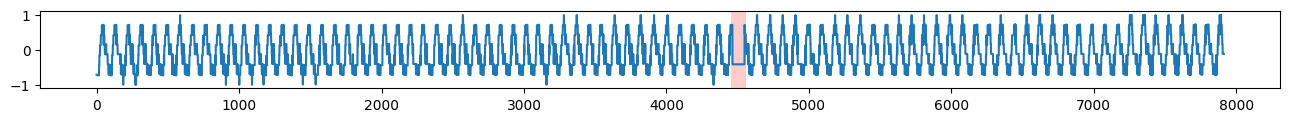

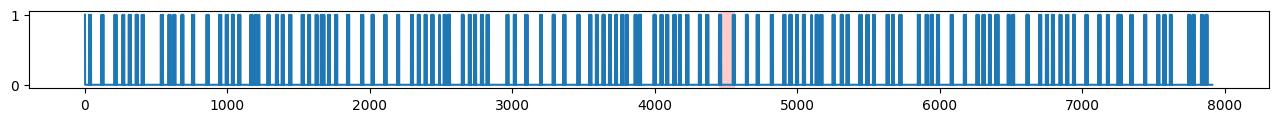

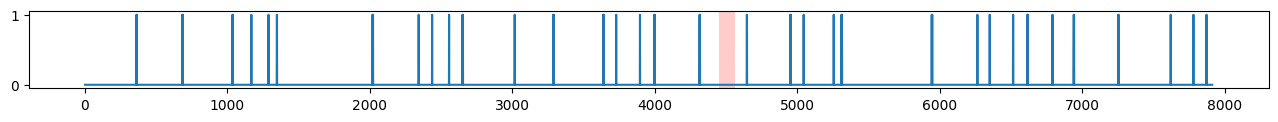

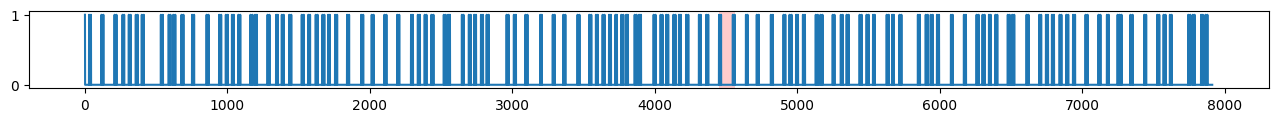

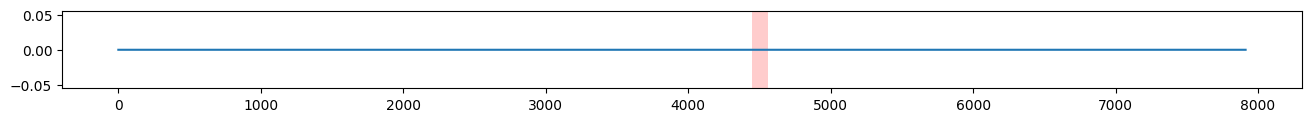

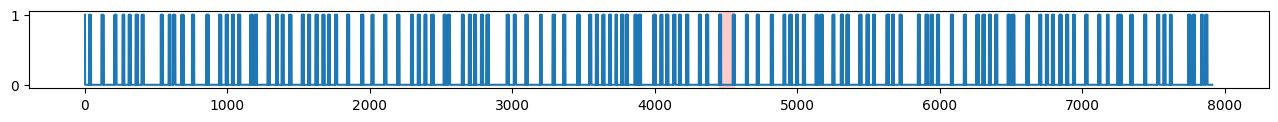

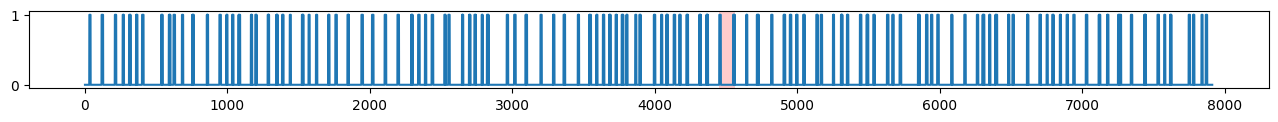

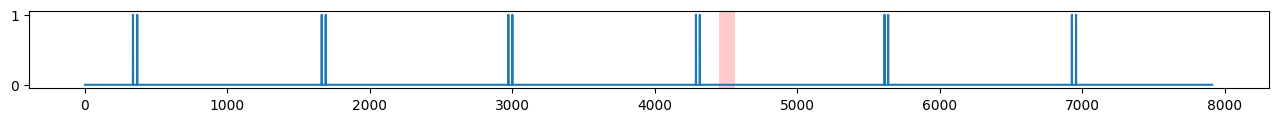

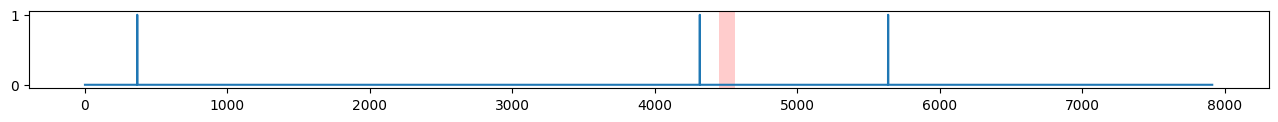

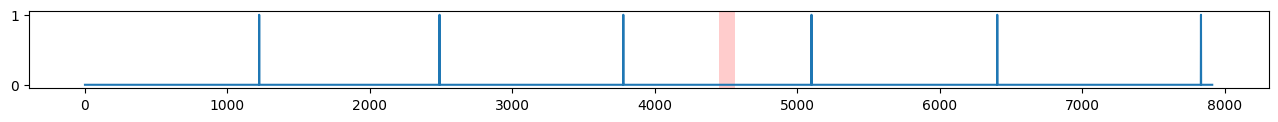

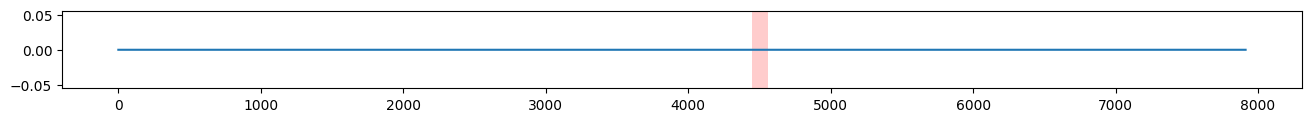

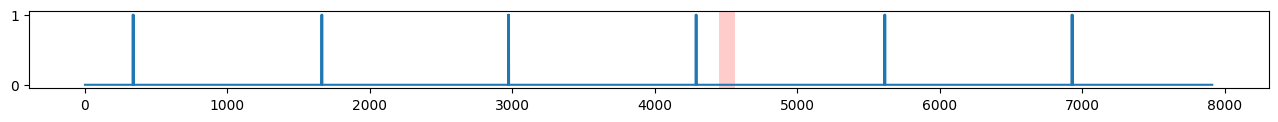

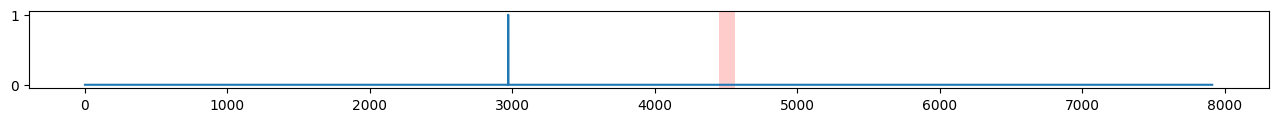

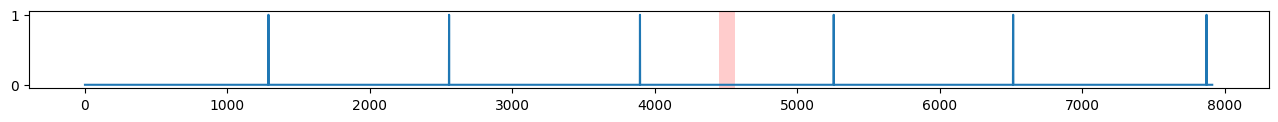

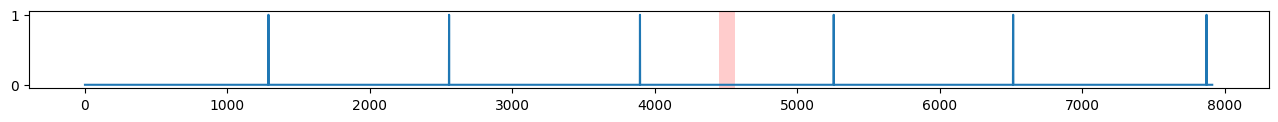

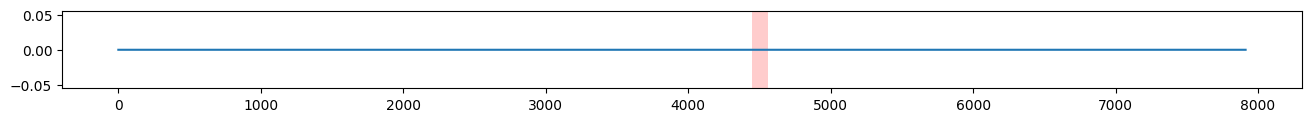

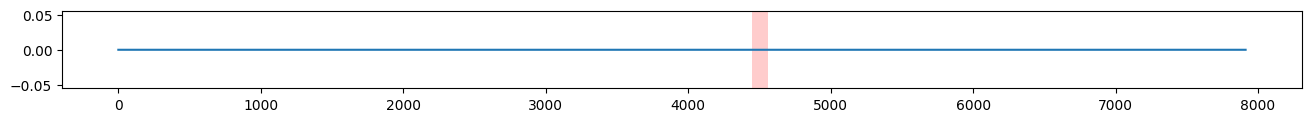

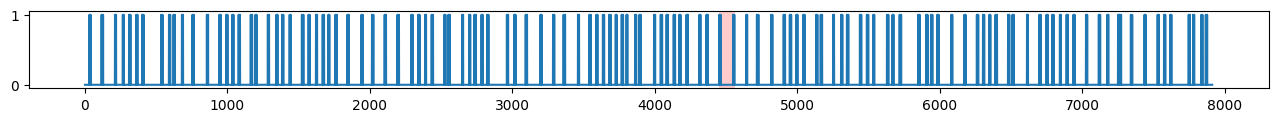

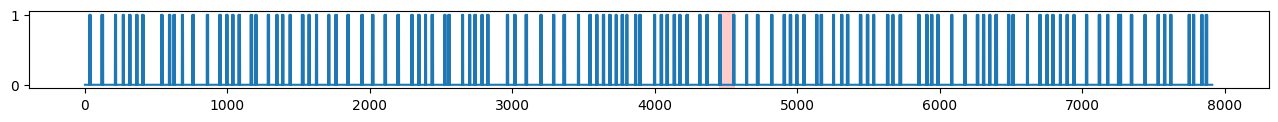

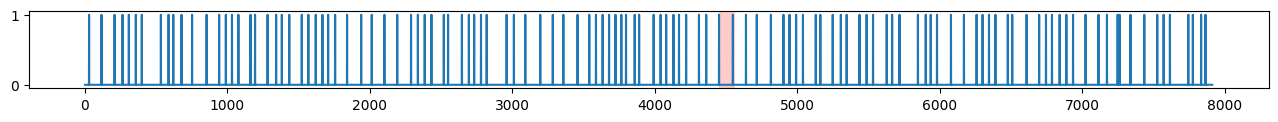

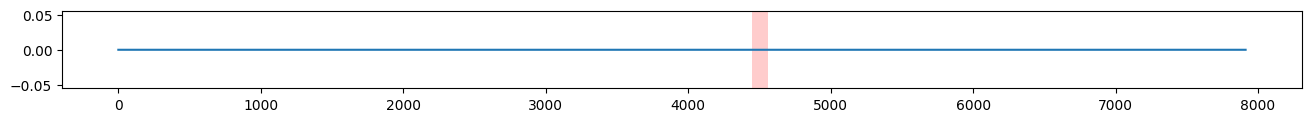

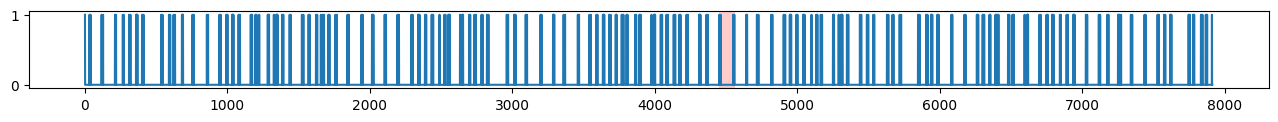

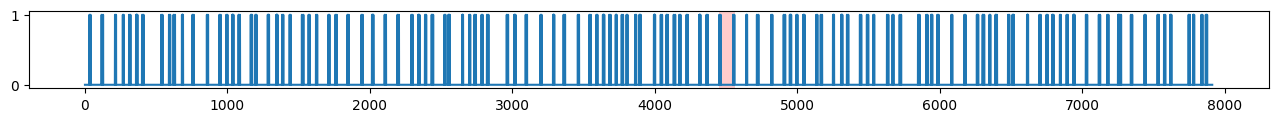

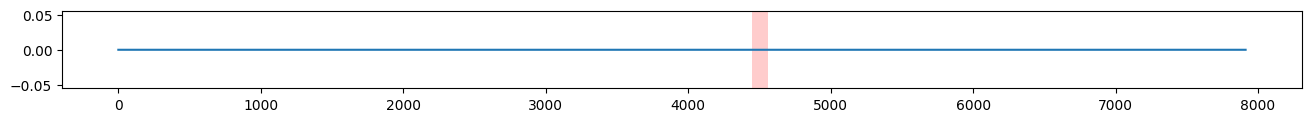

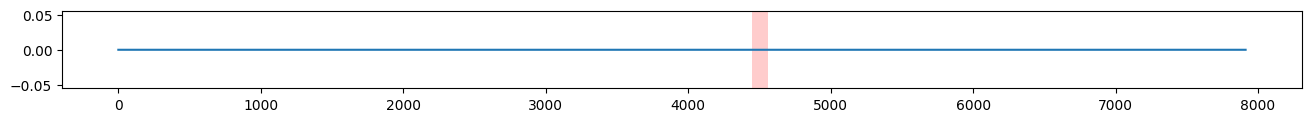

In [14]:
for ts_idx in range(len(ts_test.T)):
    plt.figure(figsize=(16,1))
    plt.plot(ts_test.T[ts_idx])
    plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)

In [15]:
ts = ts_test[:,0]
ground_truth = np.zeros_like(ts)
ground_truth[anomaly_start:anomaly_end] = 1.

In [26]:
block_length = 100
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(7814, 100) (7814,)


In [27]:
lr = LinearRegression().fit(X_train, Y_train)
beta = lr.coef_
b = lr.intercept_
inv_hess = len(X_train) * np.linalg.inv(X_train.T @ X_train)
params = (beta, b, inv_hess)

In [28]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(compute_loo_linear_approx(i, i, X_train, Y_train, X_train, Y_train, params))
time_block_loos = np.array(time_block_loos)

Compute LOO: 100%|███████████████████████| 7814/7814 [00:00<00:00, 27374.32it/s]


In [29]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

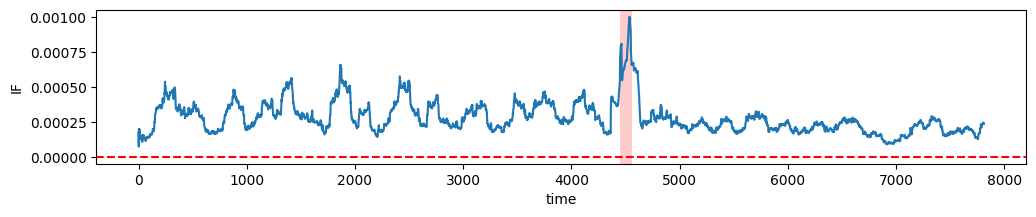

In [30]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_point_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [31]:
anomaly_scores = scale_influence_functions(time_point_loos, block_length)

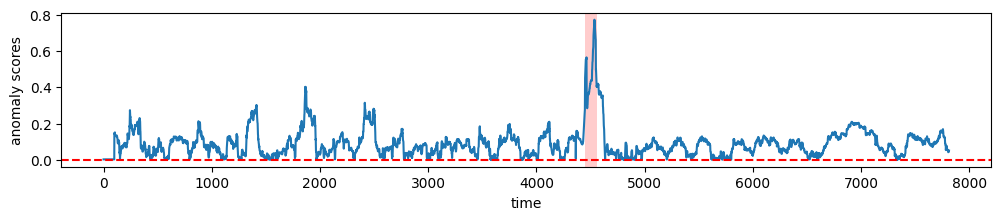

In [32]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = anomaly_scores
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [40]:
contam_ratio = block_length / len(ts)
detected_outliers = np.zeros_like(ts)
detected_outliers = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)

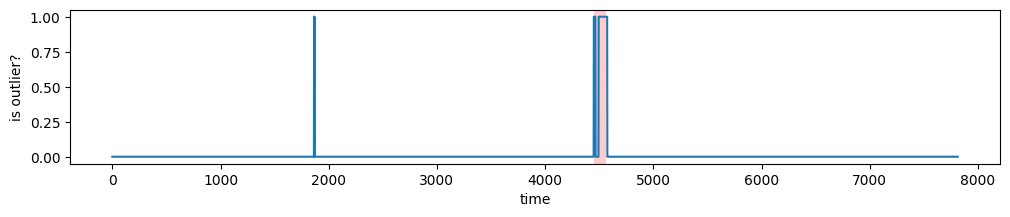

In [34]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(detected_outliers)] = detected_outliers
plt.plot(loos_viz)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("is outlier?")
plt.xlabel("time")
plt.show()

In [41]:
prec, rec, f1 = eval_anomaly_detector(ground_truth[:len(detected_outliers)], detected_outliers)

precision: 0.818 recall: 0.736 F1: 0.775


#### ARX
- remove both main time series and auxiliary covariates

In [207]:
block_length = 100
X_train, Y_train = split_time_series(ts_test, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts_test, X_train)
Y_train = Y_train[:,0]
seq_len, _, n_series = X_train.shape
print(X_train.shape)
X_train = X_train.reshape(-1, block_length*n_series)
print(X_train.shape, Y_train.shape)

(7814, 100, 25)
(7814, 2500) (7814,)


In [208]:
lr = LinearRegression().fit(X_train, Y_train)
beta = lr.coef_
b = lr.intercept_
try:
    inv_hess = len(X_train) * np.linalg.inv(X_train.T @ X_train)
except:
    inv_hess = len(X_train) * np.linalg.pinv(X_train.T @ X_train)
params = (beta, b, inv_hess)

In [209]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(compute_loo_linear_approx(i, i, X_train, Y_train, X_train, Y_train, params))
time_block_loos = np.array(time_block_loos)

Compute LOO: 100%|█████████████████████████| 7814/7814 [00:31<00:00, 245.39it/s]


In [210]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

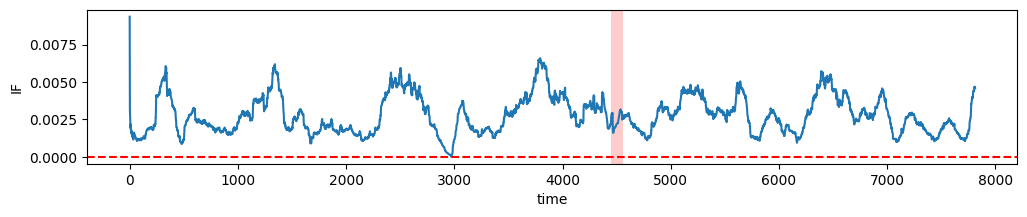

In [211]:
plt.figure(figsize=(12,2))
loos_viz = np.ones(len(ts_test)) * np.nan
loos_viz[:X_train.shape[0]] = time_point_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

#### IF with auxiliary covariates
- remove only auxiliary covariates

In [222]:
remove_cov_idxs = np.arange(1*block_length, n_series*block_length)

In [223]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(compute_loo_linear_approx(i, i, X_train, Y_train, X_train, Y_train, params, remove_cov_idxs))
time_block_loos = np.array(time_block_loos)

Compute LOO: 100%|█████████████████████████| 7814/7814 [00:33<00:00, 236.38it/s]


In [224]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

In [225]:
anomaly_scores = scale_influence_functions(time_point_loos, block_length)

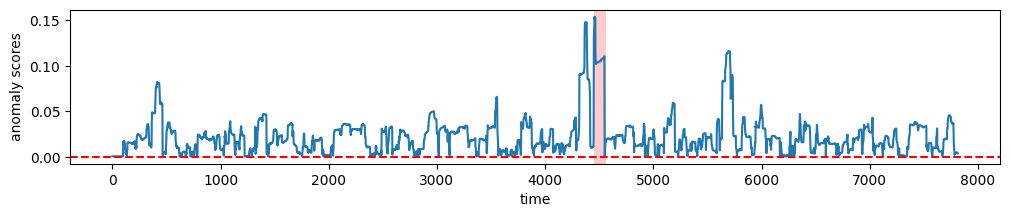

In [226]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = anomaly_scores
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [237]:
contam_ratio = block_length / len(ts)
detected_outliers = np.zeros_like(ts)
detected_outliers = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)

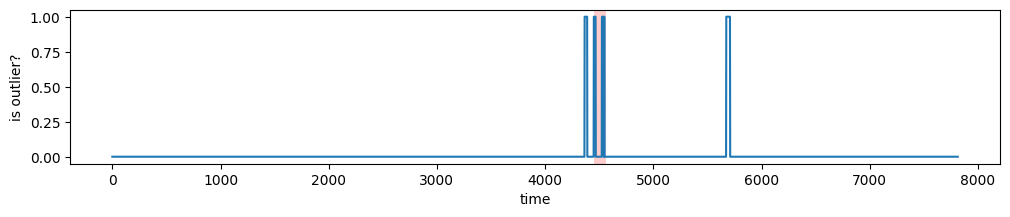

In [234]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(detected_outliers)] = detected_outliers
plt.plot(loos_viz)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("is outlier?")
plt.xlabel("time")
plt.show()

In [238]:
prec, rec, f1 = eval_anomaly_detector(ground_truth[:len(detected_outliers)], detected_outliers)

precision: 0.374 recall: 0.336 F1: 0.354


- remove only main time series

In [216]:
remove_cov_idxs = np.arange(1*block_length)

In [217]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(compute_loo_linear_approx(i, i, X_train, Y_train, X_train, Y_train, params, remove_cov_idxs))
time_block_loos = np.array(time_block_loos)

Compute LOO: 100%|██████████████████████████| 7814/7814 [02:27<00:00, 52.92it/s]


In [218]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

In [220]:
anomaly_scores = scale_influence_functions(time_point_loos, block_length)

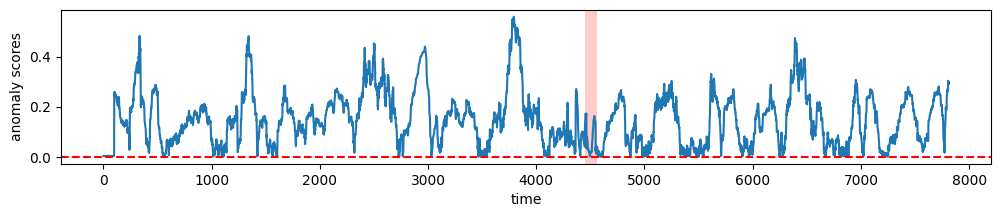

In [221]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = anomaly_scores
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()